# Classical Computation on a Quantum Computer

## Contents

1. [Introduction](#intro)
1. [Taking Out the Garbage](#garage)
2. [Consulting and Oracle](#oracle)

## 1. Introduction <a id='intro'></a>

One consequence of having a universal set of quantum gates is the ability to reproduce any classical computation. We simply need to compile the classical computation down into the Boolean logic gates that we saw in *The Atoms of Computation*, and then reproduce these on a quantum computer.

This demonstrates an important fact about quantum computers: they can do anything that a classical computer can do, and they can do so with at least the same computational complexity. Though it is not the aim to use quantum computers for tasks at which classical computers already excel, this is nevertheless a good demonstration that quantum computers can solve a general range of problems.

Furthermore, problems that require quantum solutions often involve components that can be tackled using classical algorithms. In some cases, these classical parts can be done on classical hardware. However, in many cases, the classical algorithm must be run on inputs that exist in a superposition state. This requires the classical algorithm to be run on quantum hardware. In this section we introduce some of the ideas used when doing this.



## 2. Consulting an Oracle <a id='oracle'></a>

Many quantum algorithms are based around the analysis of some function $f(x)$. Often these algorithms simply assume the existence of some 'black box' implementation of this function, which we can give an input $x$ and receive the corresponding output $f(x)$. This is referred to as an *oracle*.

The advantage of thinking of the oracle in this abstract way allows us to concentrate on the quantum techniques we use to analyze the function, rather than the function itself. 

In order to understand how an oracles work within a quantum algorithm, we need to be specific about how they are defined. One of the  main forms that oracles take is that of *Boolean oracles*. These are described by the following unitary evolution,

$$
U_f \left|x , \bar 0 \right\rangle = \left|x, f(x)\right\rangle.
$$

Here $\left|x , \bar 0 \right\rangle = \left|x \right\rangle \otimes \left|\bar 0 \right\rangle$ is used to represent a multi-qubit state consisting of two registers. The first register is in state $\left|x\right\rangle$, where $x$ is a binary representation of the input to our function. The number of qubits in this register is the number of bits required to represent the inputs.

The job of the second register is to similarly encode the output. Specifically, the state of this register after applying $U_f$ will be a binary representation of the output $\left|f(x)\right\rangle$, and this register will consist of as many qubits as are required for this. This initial state $\left|\bar 0 \right\rangle$ for this register represents the state for which all qubits are $\left|0 \right\rangle$. For other initial states, applying $U_f$ will lead to different results. The specific results that arise will depend on how we define the unitary $U_f$.

Another form of oracle is the *Phase oracle*. In this case, there is no additional register to hold the output $f(x)$. Instead its value determines the phase acquired by a given state

$$
P_f \left|x \right\rangle = (-1)^{f(x)} \left|x \right\rangle.
$$

For phase oracles, the output $f(x)$ is typically a simple bit value of $0$ or $1$, corresponding to inducing phaes of $+1$ and $-1$, respectively.

## 3. Taking Out the Garbage <a id='garbage'></a>

The functions evaluated by an oracle are typically those that can be evaluated efficiently on a classical computer. However, the need to implement it as a unitary in one of the forms shown above means that it must instead be implemented using quantum gates. However, this is not quite as simple as just taking the Boolean gates that can implement the classical algorithm, and replacing them with their classical counterparts.

One issue that we must take care of is that of reversibility. A unitary of the form $U = \sum_x \left| f(x) \right\rangle \left\langle x \right|$ is only possible if every unique input $x$ results in a unique output $f(x)$, which is not true in general. However, we can force it to e true by simply including a copy of the input in the output.


However, we can make it reversible by simply adding a copy of the input in the output. Specifically, we wish to achieve the following. It is this that leads us to the form for Boolean oracles as we saw earlier
$$
U_f \left|x,\bar 0 \right\rangle = \left| x,f(x) \right\rangle
$$

With the computation written as a unitary, we are able to consider the effect of applying it to superposition states. For example, let us take the superposition over all possible inputs $x$ (unnormalized for simplicity). This will result in a superposition of all possible input/output pairs,

$$
U_f \sum_x \left|x,0\right\rangle = \sum_x \left|x,f(x)\right\rangle.
$$

When adapting classical algorithms, we also need to take care that these superpositions behave as we need them to. Classical algorithms typically do not only compute the desired output, but will also create additional information along the way. Such additional remnants of a computation do not pose a significant problem classically, and the memory they take up can easily be recovered by deleting them. From a quantum perspective, however, things are not so easy. 

For example, consider the case that a classical algorithm peforms the following process,
$$
V_f \left|x,\bar 0, \bar 0 \right\rangle = \left| x,f(x), g(x) \right\rangle
$$
Here we see a third register, which is used as a 'scratchpad' for the classical algorithm. We will refer ro information that is left in this register at the end of the computation is as the 'garbage', $g(x)$. Let us use $V_f$ to denote a unitary that implements the above.

Quantum algorithms are typically built upon interference effects. The simplest such effect is to create a superposition using some unitary, and then remove it using the inverse of that unitary. The entire effect of this is, of course, trivial. However, we must ensure that our quantum computer is at least able to do such trivial things.

For example, suppose some process within our quantum computation has given us the superposition state $\sum_x \left|x,f(x)\right\rangle$, and we are required to return this to the state $\sum_x \left|x,0\right\rangle$. For this we could simply apply $U_f^\dagger$. The ability to apply this follows directly from knowing a circuit that would apply $U_f$, since we would simply need to replace each gate in the circuit with its inverse and reverse the order.

However, suppose we don't know how to apply $U_f$, but instead know how to apply $V_f$. This means that we can't apply $U_f^\dagger$ here, but could use $V_f^\dagger$. Unfortunately, the presence of the garbage means that it won't have the same effect.

For an explicit example of this we can take a very simple case. We'll restrict $x$, $f(x)$ and $g(x)$ to all consist of just a single bit. We'll also use $f(x) = x$ and $g(x) = x$, each of which can be acheived with just a single `cx` gate controlled on the input register.

Specifically, the circuit to implement $U_f$ is just the following single `cx` between the single bit of the input and output registers.

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute

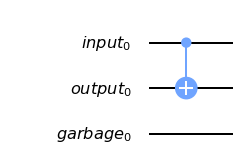

In [17]:
input_bit = QuantumRegister(1, 'input')
output_bit = QuantumRegister(1, 'output')
garbage_bit = QuantumRegister(1, 'garbage')

Uf = QuantumCircuit(input_bit, output_bit, garbage_bit)
Uf.cx(input_bit[0], output_bit[0])

Uf.draw(output='mpl',justify='none')

For $V_f$, where we also need to make a copy of the input for the garbage, we can use the following two `cx` gates.

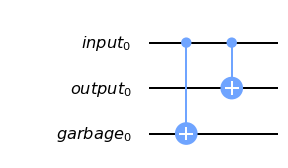

In [24]:
Vf = QuantumCircuit(input_bit, output_bit, garbage_bit)
Vf.cx(input_bit[0], garbage_bit[0])
Vf.cx(input_bit[0], output_bit[0])


Vf.draw(output='mpl',justify='none')

Now we can look at the effect of first applying $U_f$, and then applying $V_f^{\dagger}$. The net effect is the following circuit.

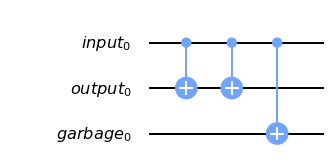

In [25]:
qc = Uf + Vf.inverse()

qc.draw(output='mpl',justify='none')

This circuit begins with two identical `cx` gates, whose effects cancel each other out. All that remains is the final `cx` between the input and garbage registers. Mathematically, this means

$$
V_f^\dagger U_f \left| x,f(x),0 \right\rangle = \left| x , 0 ,g(x) \right\rangle.
$$

This does not leave us with the state we require, but instead leaves the first qubit entangled with unwanted garbage. Any subsequent steps in an algorithm will therefore not run as expected, since the state is not the one that we need.

For this reason we need a way of removing classical garbage from our quantum algorithms. This can be done by a method known as 'uncomputation. We simply need to take another blank variable and apply $V_f$


$$
\left| x, 0, 0, 0 \right\rangle \rightarrow \left| x,f(x),g(x),0 \right\rangle.
$$

Then we apply a set of controlled-NOT gates, each controlled on one of the qubits used to encode the output, and targeted on the corresponding quit in the extra blank variable. This effectively copyies the information over.

$$
\left| x,f(x),g(x),0 \right\rangle \rightarrow \left| x,f(x),g(x),f(x) \right\rangle.
$$

Finally we apply $V_f^\dagger$, which undoes the original computation.

$$
\left| x,f(x),g(x),0 \right\rangle \rightarrow \left| x,0,0,f(x) \right\rangle.
$$

The copied output nevertheless remains. The net effect is to perform the computation without garbage, and hence acheiveS our desired $U_f$.

With this method, and all of the others covered in this chapter, we now have all the tools we need to create quantum algorithms. Now we can move on to seeing those algorithms in action.

In [26]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.14.1',
 'qiskit-aer': '0.5.1',
 'qiskit-ignis': '0.3.0',
 'qiskit-ibmq-provider': '0.7.1',
 'qiskit-aqua': '0.7.1',
 'qiskit': '0.19.2'}